In [1]:
from __future__ import division, print_function

import pandas as pd
import numpy as np
import tensorflow as tf
from IPython.display import Image, display, clear_output

from tensorflow.python.framework.ops import reset_default_graph

# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
from matplotlib.pyplot import cm
from matplotlib.mlab import PCA as mlabPCA

%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [2]:
data = pd.read_csv("data.csv", delimiter=",")

#data = data.reindex(np.random.permutation(data.index))

cancer_type = np.array(data[[0]]) # finding types of cancer
sample_type = np.array(data[[1]]) # finding types of sample
sample_type = sample_type - 1

data.drop(data.columns[[0,1]], axis=1, inplace=True)

num_samples = data.shape[0]
num_features = data.shape[1]

types = ["BLCA", "BRCA", "COAD/READ", "DLBC", "ESCA", "GBM", "HNSC", "KIRC",
         "LAML", "LGG", "LUAD", "LUSC", "NOT CLAS", "PRAD",          
         "SCLC", "SKCM", "STAD", "THCA", "UCEC"]

drug_target = np.array(pd.read_csv("drug_target.csv", delimiter=","))[:,1:]
IC50 = np.array(pd.read_csv("IC50.csv", delimiter=","))[6:,2:]


data_tmp = np.array(data)

In [3]:
i = (pd.read_csv("IC50.csv", delimiter=","))
new = i.iloc[4]
i.drop(i.columns[[0]], axis=1)
i = pd.DataFrame(i[6:])
i = i.rename(columns=new)
i = i.reindex(range(len(i)))

IC_name = np.array(new)

In [4]:
d = pd.read_csv("drug_target.csv", delimiter=",")
d_name = np.array(list(d))

In [5]:
intersect = np.intersect1d(d_name,IC_name)

# these drugs appears twice with different responces
intersect = intersect[intersect!='AZD6244']
intersect = intersect[intersect!='AZD6482']
intersect = intersect[intersect!='BMS-536924']
intersect = intersect[intersect!='BMS-708163']
intersect = intersect[intersect!='Bicalutamide']
intersect = intersect[intersect!='CHIR-99021']
intersect = intersect[intersect!='GSK269962A']
intersect = intersect[intersect!='JQ1']
intersect = intersect[intersect!='Olaparib']
intersect = intersect[intersect!='UNC0638']


In [17]:
intersect

array(['(5Z)-7-Oxozeaenol', '17-AAG', '5-Fluorouracil', '681640',
       'A-443654', 'A-770041', 'ABT-263', 'ABT-869', 'ABT-888', 'AC220',
       'AG-014699', 'AICAR', 'AKT inhibitor VIII', 'AMG-706', 'AP-24534',
       'AR-42', 'AS601245', 'AS605240', 'AT-7519', 'ATRA', 'AUY922',
       'AV-951', 'AZ628', 'AZD-0530', 'AZD7762', 'AZD8055', 'Afatinib',
       'Afatinib (rescreen)', 'Axitinib', 'BAY 61-3606', 'BI-2536',
       'BIRB 0796', 'BIX02189', 'BMN-673', 'BMS-345541', 'BMS-509744',
       'BMS-754807', 'BX-795', 'BX-912', 'Bexarotene', 'Bleomycin',
       'Bleomycin (50 uM)', 'Bortezomib', 'Bosutinib', 'Bryostatin 1',
       'CAL-101', 'CAY10603', 'CCT007093', 'CCT018159', 'CEP-701',
       'CGP-082996', 'CGP-60474', 'CH5424802', 'CI-1040', 'CMK',
       'CP466722', 'CP724714', 'CUDC-101', 'CX-5461', 'Camptothecin',
       'Cetuximab', 'Cisplatin', 'Crizotinib', 'Cyclopamine', 'Cytarabine',
       'DMOG', 'Dabrafenib', 'Dasatinib', 'Docetaxel', 'Doxorubicin',
       'EHT 1864', '

# Finding drugs from Nikolais list 

In [6]:
a = list(intersect)
aa = [x.lower() for x in a]
aaa = [x.replace('-','')
        .replace('(','')
        .replace(')','')
        .replace(' ','')
        .replace('/','') for x in aa]

In [7]:
nikolai = ['5-Fluorouracil', # 5FU
           'Cetuximab',     # erbitux
           'SN-38',]         # Irinotecan

In [8]:
drug_clean_n = []
IC_clean_n = []


for g in nikolai:
    drug_clean_n += [np.array(d[[d.columns.get_loc(g)]])]
    IC_clean_n += [np.array(i[[i.columns.get_loc(g)]])]

drug_clean_n = np.array(drug_clean_n).reshape(3,212)
IC_clean_n = np.array(IC_clean_n).reshape(3, 1001)

IC_clean_n = IC_clean_n.reshape(-1)
IC_clean_n[np.where((IC_clean_n != 'S') & (IC_clean_n != 'R'))] = 0
IC_clean_n[IC_clean_n == 'S'] = 1
IC_clean_n[IC_clean_n == 'R'] = 2
IC_clean_n = IC_clean_n.reshape(3,1001)


In [9]:
print(IC_clean_n.shape)
print(drug_clean_n.shape)

(3, 1001)
(3, 212)


# Original

In [10]:
drug_clean = []
IC_clean = []


for g in range(len(intersect)):
    drug_clean += [np.array(d[[d.columns.get_loc(intersect[g])]])]
    IC_clean += [np.array(i[[i.columns.get_loc(intersect[g])]])]

drug_clean = np.array(drug_clean).reshape(242,212)
IC_clean = np.array(IC_clean).reshape(242, 1001)

IC_clean = IC_clean.reshape(-1)
IC_clean[np.where((IC_clean != 'S') & (IC_clean != 'R'))] = 0
IC_clean[IC_clean == 'S'] = 1
IC_clean[IC_clean == 'R'] = 2
IC_clean = IC_clean.reshape(242,1001)

In [11]:
242242 - np.sum(IC_clean == 2) - np.sum(IC_clean == 1)

49522

In [12]:
print(IC_clean[:20].shape)
print(drug_clean[:20].shape)

(20, 1001)
(20, 212)


In [16]:
drug_clean

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Thresholding

In [14]:
y = np.bincount(np.squeeze(cancer_type))
ii = np.nonzero(y)[0]
count = np.vstack((ii,y[ii])).T
keep = count[:,1] > 34
to_keep = ii[keep]

idx_keep = np.where(cancer_type == to_keep)[0]

cancer_type = cancer_type[idx_keep]
sample_type = sample_type[idx_keep]
data = data_tmp[idx_keep]

drug_keep = np.where((sample_type == 0) & (cancer_type == to_keep))[0]


IC50 = IC_clean.transpose(1,0)[drug_keep]

IC50_n = IC_clean_n.transpose(1,0)[drug_keep]

# Creating data sets for each cancer type

In [15]:
#for _, i in enumerate(np.unique(cancer_type)): # i represents the cancer type

tmp_keep = np.where((sample_type == 0) & (cancer_type == 4))[0] # only keeping the cell lines

data_tmp = data[tmp_keep] # samples to keep

IC50_tmp = IC50[tmp_keep].reshape(-1,order='F')

IC50_tmp_onehot = np.zeros([len(IC50_tmp), len(np.unique(IC50_tmp))]) # one hot response
IC50_tmp_onehot[np.arange(len(IC50_tmp)), IC50_tmp.astype(int)] = 1

drug_tmp = np.repeat(drug_clean,data_tmp.shape[0],axis=0)

data_tmp_ = np.tile(data_tmp,(drug_clean.shape[0],1))

# Splitting data into components

In [16]:
# MUTATION
data = np.array(data)
MUT = np.hstack([data[:,:98],
                 data[:,455:549],
                 data[:,666:716],
                 data[:,1024:1250]])

# Hypermetabolics
HM = np.vstack(data[:,98:455])

CNV = np.hstack([data[:,550:665],
                 data[:,717:1023]])

# Plotting the reduced spaces

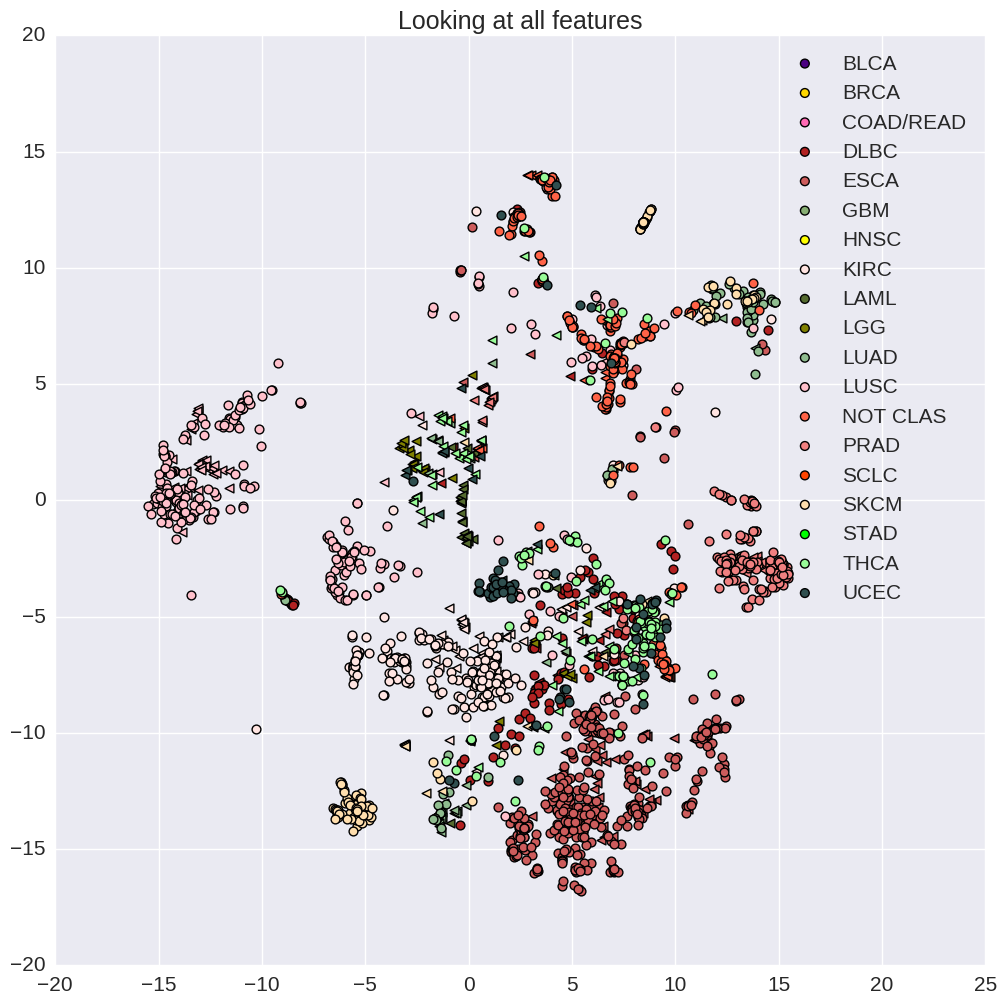

In [15]:
data_proj = TSNE(random_state=RS).fit_transform(data)

plt.figure(figsize=(12, 12))
colors = matplotlib.colors.cnames.items()
m = ["<", "o"]

for j in range(19):
    plt.scatter(data_proj[np.where((cancer_type==j) & (sample_type==0))[0],0],
                data_proj[np.where((cancer_type==j) & (sample_type==0))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[0])
    plt.scatter(data_proj[np.where((cancer_type==j) & (sample_type==1))[0],0],
                data_proj[np.where((cancer_type==j) & (sample_type==1))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[1],
                label = "%s"%types[j])

plt.title("Looking at all features")
legend = plt.legend(loc = 'upper right')
frame = legend.get_frame()
frame.set_facecolor('0.90')

plt.ylim([-20,20])    
plt.xlim([-20,25])

plt.show()

In [16]:
MUT_proj = TSNE(random_state=RS).fit_transform(MUT)

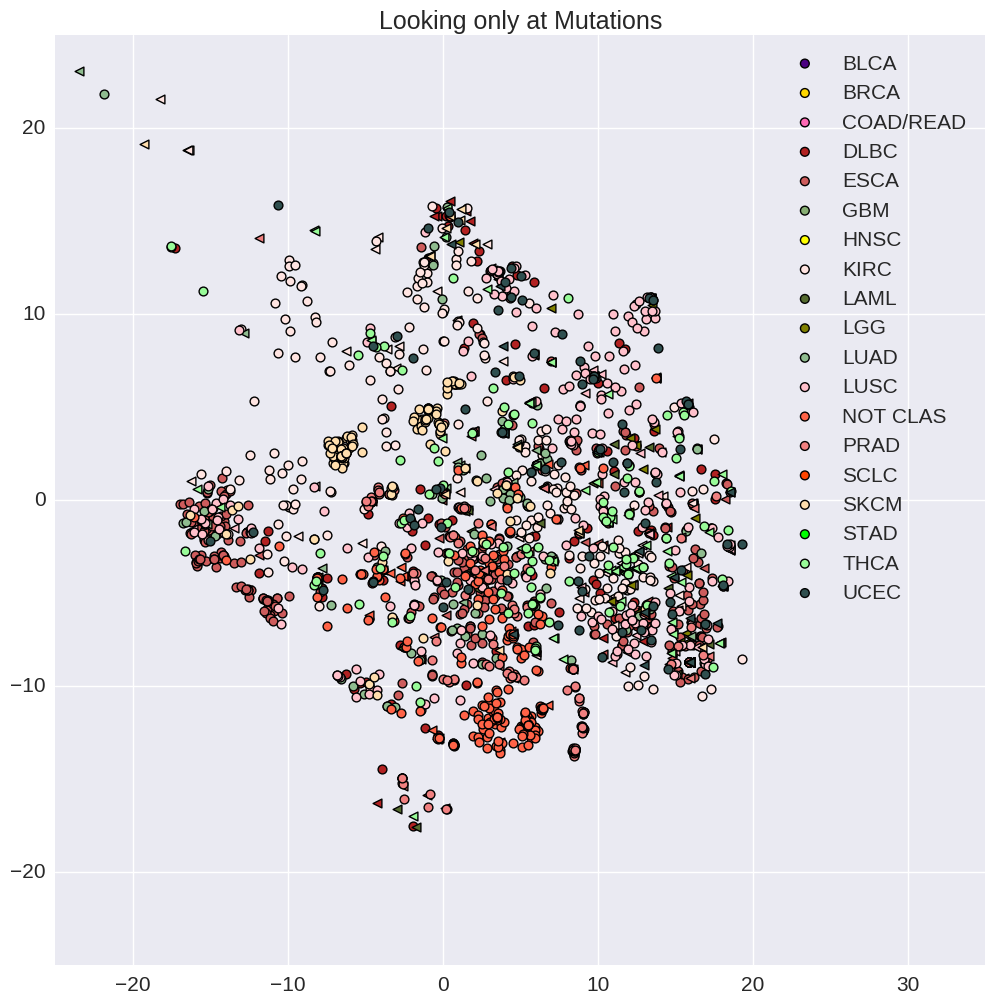

In [17]:
plt.figure(figsize=(12, 12))
colors = matplotlib.colors.cnames.items()
m = ["<", "o"]

for j in range(19):
    plt.scatter(MUT_proj[np.where((cancer_type==j) & (sample_type==0))[0],0],
                MUT_proj[np.where((cancer_type==j) & (sample_type==0))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[0])
    plt.scatter(MUT_proj[np.where((cancer_type==j) & (sample_type==1))[0],0],
                MUT_proj[np.where((cancer_type==j) & (sample_type==1))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[1],
                label = "%s"%types[j])

plt.title("Looking only at Mutations")
legend = plt.legend(loc = 'upper right')
frame = legend.get_frame()
frame.set_facecolor('0.90')

plt.ylim([-25,25])    
plt.xlim([-25,35])

plt.show()

In [18]:
HM_proj = TSNE(random_state=RS).fit_transform(HM)


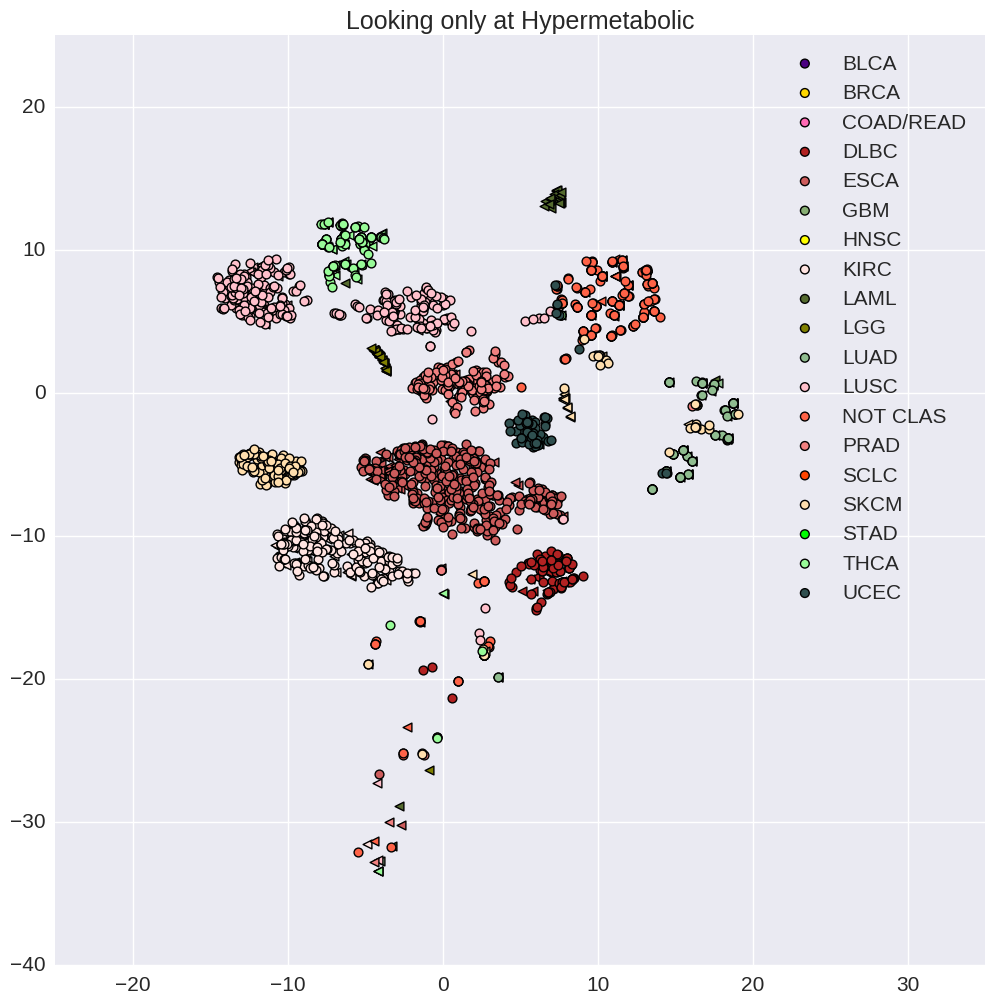

In [19]:
plt.figure(figsize=(12, 12))
colors = matplotlib.colors.cnames.items()
m = ["<", "o"]

for j in range(19):
    plt.scatter(HM_proj[np.where((cancer_type==j) & (sample_type==0))[0],0],
                HM_proj[np.where((cancer_type==j) & (sample_type==0))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[0])
    
    plt.scatter(HM_proj[np.where((cancer_type==j) & (sample_type==1))[0],0],
                HM_proj[np.where((cancer_type==j) & (sample_type==1))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[1],
                label = "%s"%types[j])

plt.title("Looking only at Hypermetabolic")
legend = plt.legend(loc = 'upper right')
frame = legend.get_frame()
frame.set_facecolor('0.90')

plt.ylim([-40,25])    
plt.xlim([-25,35])

plt.show()

In [20]:
CNV_proj = TSNE(random_state=RS).fit_transform(CNV)


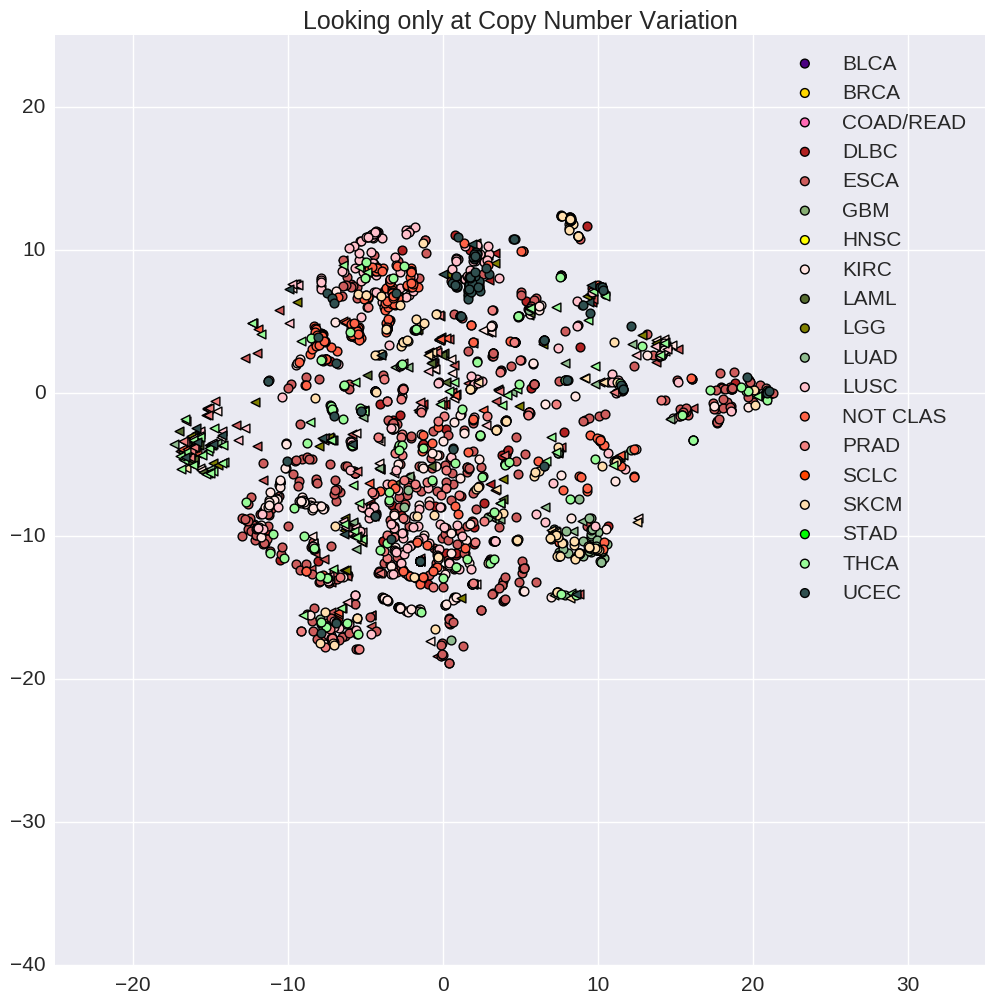

In [21]:
plt.figure(figsize=(12, 12))
colors = matplotlib.colors.cnames.items()
m = ["<", "o"]

for j in range(19):
    plt.scatter(CNV_proj[np.where((cancer_type==j) & (sample_type==0))[0],0],
                CNV_proj[np.where((cancer_type==j) & (sample_type==0))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[0])
    
    plt.scatter(CNV_proj[np.where((cancer_type==j) & (sample_type==1))[0],0],
                CNV_proj[np.where((cancer_type==j) & (sample_type==1))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[1],
                label = "%s"%types[j])

plt.title("Looking only at Copy Number Variation")
legend = plt.legend(loc = 'upper right')
frame = legend.get_frame()
frame.set_facecolor('0.90')

plt.ylim([-40,25])    
plt.xlim([-25,35])

plt.show()

In [22]:
MUT_HM = np.hstack([MUT,
                    HM])

MUT_HM_proj = TSNE(random_state=RS).fit_transform(MUT_HM)


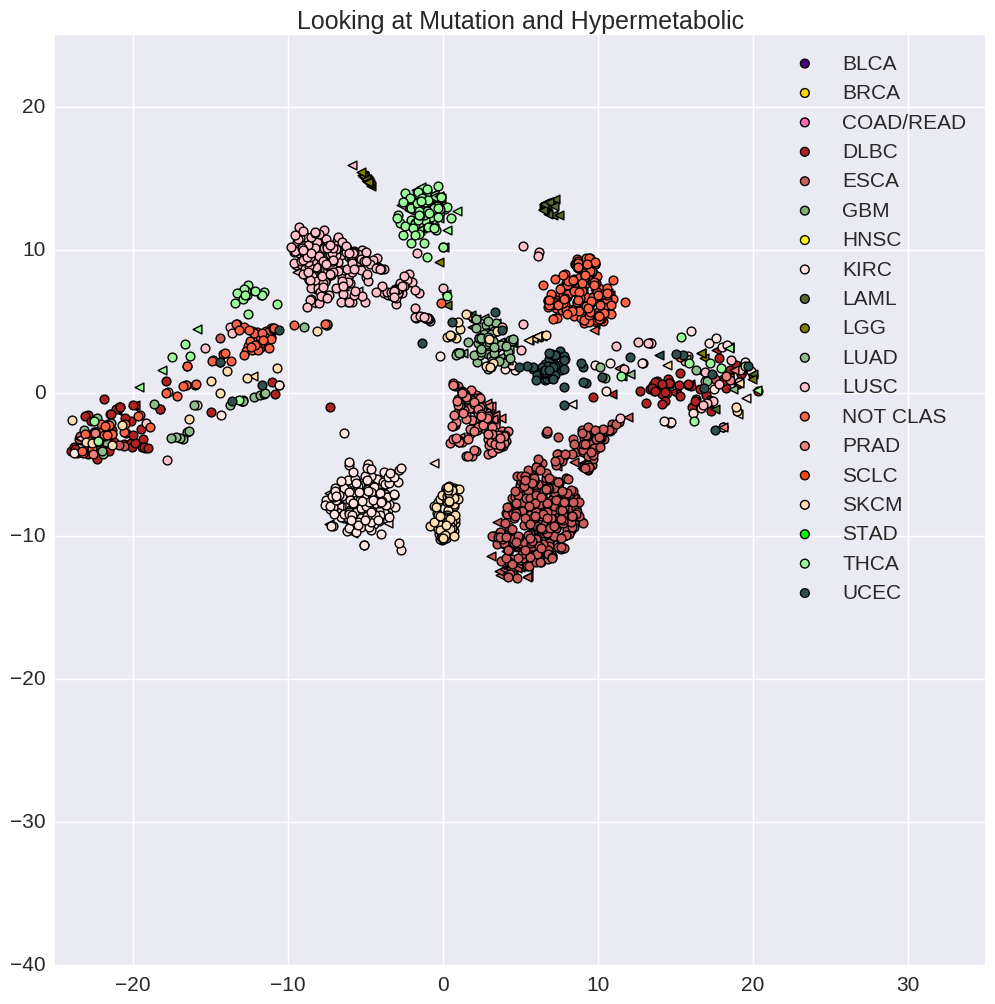

In [23]:
plt.figure(figsize=(12, 12))
colors = matplotlib.colors.cnames.items()
m = ["<", "o"]

for j in range(19):
    plt.scatter(MUT_HM_proj[np.where((cancer_type==j) & (sample_type==0))[0],0],
                MUT_HM_proj[np.where((cancer_type==j) & (sample_type==0))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[0])
    
    plt.scatter(MUT_HM_proj[np.where((cancer_type==j) & (sample_type==1))[0],0],
                MUT_HM_proj[np.where((cancer_type==j) & (sample_type==1))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[1],
                label = "%s"%types[j])

plt.title("Looking at Mutation and Hypermetabolic")
legend = plt.legend(loc = 'upper right')
frame = legend.get_frame()
frame.set_facecolor('0.90')

plt.ylim([-40,25])    
plt.xlim([-25,35])

plt.show()

In [ ]:
MUT_CNV = np.hstack([MUT,
                    CNV])

MUT_CNV_proj = TSNE(random_state=RS).fit_transform(MUT_CNV)


In [ ]:
plt.figure(figsize=(12, 12))
colors = matplotlib.colors.cnames.items()
m = ["<", "o"]

for j in range(19):
    plt.scatter(MUT_CNV_proj[np.where((cancer_type==j) & (sample_type==0))[0],0],
                MUT_CNV_proj[np.where((cancer_type==j) & (sample_type==0))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[0])
    
    plt.scatter(MUT_CNV_proj[np.where((cancer_type==j) & (sample_type==1))[0],0],
                MUT_CNV_proj[np.where((cancer_type==j) & (sample_type==1))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[1],
                label = "%s"%types[j])

plt.title("Looking at Mutation and Copy Number Variation")
legend = plt.legend(loc = 'upper right')
frame = legend.get_frame()
frame.set_facecolor('0.90')

plt.ylim([-40,25])    
plt.xlim([-25,35])

plt.show()

In [ ]:
HM_CNV = np.hstack([HM,
                    CNV])

HM_CNV_proj = TSNE(random_state=RS).fit_transform(HM_CNV)


In [ ]:
plt.figure(figsize=(12, 12))
colors = matplotlib.colors.cnames.items()
m = ["<", "o"]

for j in range(19):
    plt.scatter(HM_CNV_proj[np.where((cancer_type==j) & (sample_type==0))[0],0],
                HM_CNV_proj[np.where((cancer_type==j) & (sample_type==0))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[0])
    
    plt.scatter(HM_CNV_proj[np.where((cancer_type==j) & (sample_type==1))[0],0],
                HM_CNV_proj[np.where((cancer_type==j) & (sample_type==1))[0],1],
                c=colors[j][0], s=40., lw=1, marker=m[1],
                label = "%s"%types[j])

plt.title("Looking at Hypermetabolic and Copy Number Variation")
legend = plt.legend(loc = 'upper right')
frame = legend.get_frame()
frame.set_facecolor('0.90')

plt.ylim([-40,25])    
plt.xlim([-25,35])

plt.show()

In [ ]:
"""

The t-sne indicates that we have low dimentionalities.
Next step would be to use logistic-regression with L1-regiralization.

Possiblie introduce a k-hot encoding for all features.

This will most likely reveal if a change in a feature has an impact on a given cancer-type.

After we can reduce to these features to see if this changes the representation of the unsupervised classification.


"""

# Reducing dimentionality using logistic regression

In [17]:
# MUT [0,1]
# HM [0,1]

# Make them 1-hot vectors

MUT_onehot = np.zeros([MUT.shape[0], MUT.shape[1], len(np.unique(MUT))])
for i in range(MUT.shape[0]):
    MUT_onehot[i][np.arange(MUT.shape[1]), MUT[i]] = 1

MUT_onehot = MUT_onehot.reshape(MUT.shape[0], len(np.unique(MUT))*MUT.shape[1])

HM_onehot = np.zeros([HM.shape[0], HM.shape[1], len(np.unique(HM))])
for i in range(MUT.shape[0]):
    HM_onehot[i][np.arange(HM.shape[1]), HM[i]] = 1

HM_onehot = HM_onehot.reshape(HM.shape[0], len(np.unique(HM))*HM.shape[1])

MUT_HM_onehot = np.concatenate([MUT_onehot, HM_onehot],1)

In [18]:
from sklearn import metrics, cross_validation
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(penalty="l1")
predicted = cross_validation.cross_val_predict(logreg, MUT_HM_onehot,
                                               np.squeeze(cancer_type),
                                               cv=5)
print(metrics.accuracy_score(cancer_type, predicted))
print(metrics.classification_report(cancer_type, predicted))

/home/tobias/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.975743574935
             precision    recall  f1-score   support

          3       0.99      0.96      0.98       111
          4       1.00      0.99      1.00       469
          7       1.00      0.99      1.00       251
          8       0.87      0.77      0.82        35
          9       1.00      0.97      0.99        35
         10       0.84      0.98      0.91       138
         11       1.00      0.99      0.99       322
         12       0.97      0.96      0.97       269
         13       1.00      0.97      0.99       181
         15       1.00      0.96      0.98       178
         17       0.99      0.98      0.98       161
         18       0.99      0.99      0.99        87
         23       0.84      1.00      0.91       189
         26       1.00      0.97      0.98       162
         27       0.91      0.91      0.91        66
         28       1.00      0.97      0.98       300
         29       1.00      0.92      0.96        86
         30       1.00      0.

In [19]:
from sklearn.linear_model import LogisticRegressionCV
logreg=LogisticRegressionCV(penalty="l1",cv=5,solver='liblinear')
logreg.fit(MUT_HM_onehot,np.squeeze(cancer_type))

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [18]:
for i in range(1):
    tmp = MUT_HM_onehot[i][logreg.coef_[i] != 0]
    
    tmp_onehot = np.zeros([len(tmp), 2])
    tmp_onehot[np.arange(len(tmp)), tmp.astype(int)] = 1
    tmp = np.reshape(tmp_onehot,2*len(tmp))

In [19]:
MUT_HM_onehot.shape

(3463, 1650)

In [20]:
idx_row = np.where((cancer_type == to_keep[1]) & (sample_type == 0))[0] # cell lines to keep
idx_col = np.where(logreg.coef_[0] != 0)[0] # genes to keep
test = MUT_HM_onehot[idx_row]
test_ = test[:,idx_col]
IC50_test = IC50[idx_row]

In [22]:
test_.shape

(51, 958)

In [23]:
to_keep[1]

4

In [24]:
clf = sklearn.linear_model.LogisticRegressionCV(Cs=10, fit_intercept=True, cv=5, dual=False,
                                                penalty='l1', scoring=None, solver='liblinear',
                                                tol=0.0001, max_iter=100, class_weight=None,
                                                n_jobs=1, verbose=0, refit=True, intercept_scaling=1.0,
                                                multi_class='ovr', random_state=None)

In [25]:
clf.fit(MUT_HM_onehot, cancer_type)

/home/tobias/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [ ]:
np.sum(clf.coef_,0).shape

In [ ]:
sum(MUT_HM_weights == 0)

In [ ]:
MUT_HM_weights = clf.coef_


In [ ]:
z = []

for i in range(19):
    z += [sum(MUT_HM_weights[i]==0)]
    
    

In [83]:
IC50.shape

(791, 242)

# Looking only at Coad/Read vs Nikolai

In [46]:
i = 3

tmp_keep = np.where((sample_type == 0) & (cancer_type == i))[0] # only keeping the cell lines

idx_row = np.where((cancer_type == i) & (sample_type == 0))[0] # cell lines to keep
idx_col = np.where(logreg.coef_[0] != 0)[0] # genes to keep
data_tmp = MUT_HM_onehot[idx_row]
data_tmp_ = data_tmp[:,idx_col]

IC50_tmp = IC50_n[tmp_keep].reshape(-1,order='F')

IC50_tmp_onehot = np.zeros([len(IC50_tmp), len(np.unique(IC50_tmp))]) # one hot response
IC50_tmp_onehot[np.arange(len(IC50_tmp)), IC50_tmp.astype(int)] = 1

drug_tmp = np.repeat(drug_clean_n,data_tmp.shape[0],axis=0)

data_tmp__ = np.tile(data_tmp_,(drug_clean_n.shape[0],1))

data_con = np.concatenate([data_tmp__,drug_tmp],1)

logreg_tmp=LogisticRegression(penalty="l1")


predicted_tmp = cross_validation.cross_val_predict(logreg_tmp,
                                                   data_con[IC50_tmp != 0],
                                                   IC50_tmp[IC50_tmp != 0].astype(int),cv=5)

print(metrics.accuracy_score(IC50_tmp[IC50_tmp != 0].astype(int), predicted_tmp))
print(metrics.classification_report(IC50_tmp[IC50_tmp != 0].astype(int), predicted_tmp))


0.755102040816
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        10
          2       0.79      0.95      0.86        39

avg / total       0.63      0.76      0.68        49



In [44]:
IC50_tmp[IC50_tmp != 0]

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1,
       1, 2, 2], dtype=object)

# Looking at individual drugs

nikolai = ['5-Fluorouracil', # 5FU
           'Cetuximab',     # erbitux
           'SN-38',         # Irinotecan
           ]

In [29]:
i = 3

for n in np.array([0,1,2]):

    tmp_keep = np.where((sample_type == 0) & (cancer_type == i))[0] # only keeping the cell lines

    idx_row = np.where((cancer_type == i) & (sample_type == 0))[0] # cell lines to keep
    idx_col = np.where(logreg.coef_[0] != 0)[0] # genes to keep
    data_tmp = MUT_HM_onehot[idx_row]
    data_tmp_ = data_tmp[:,idx_col]

    IC50_tmp = IC50_n[tmp_keep,n].reshape(-1,order='F')

    IC50_tmp_onehot = np.zeros([len(IC50_tmp), len(np.unique(IC50_tmp))]) # one hot response
    IC50_tmp_onehot[np.arange(len(IC50_tmp)), IC50_tmp.astype(int)] = 1

    drug_tmp = np.repeat([drug_clean_n[n]],data_tmp.shape[0],axis=0)

    data_tmp__ = data_tmp_

    data_con = np.concatenate([data_tmp__,drug_tmp],1)

    logreg_tmp=LogisticRegression(penalty="l1")


    predicted_tmp = cross_validation.cross_val_predict(logreg_tmp, data_con,IC50_tmp.astype(int),cv=5)

    print(metrics.accuracy_score(IC50_tmp.astype(int), predicted_tmp))
    print(metrics.classification_report(IC50_tmp.astype(int), predicted_tmp))


0.684210526316
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         3
          1       0.00      0.00      0.00         3
          2       0.68      1.00      0.81        13

avg / total       0.47      0.68      0.56        19

0.526315789474
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         3
          1       0.17      0.25      0.20         4
          2       0.69      0.75      0.72        12

avg / total       0.47      0.53      0.50        19

0.736842105263
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         2
          1       0.00      0.00      0.00         3
          2       0.74      1.00      0.85        14

avg / total       0.54      0.74      0.63        19



# Looking only at Coad/Read vs All 

In [104]:
i = 3

tmp_keep = np.where((sample_type == 0) & (cancer_type == i))[0] # only keeping the cell lines

idx_row = np.where((cancer_type == i) & (sample_type == 0))[0] # cell lines to keep
idx_col = np.where(logreg.coef_[0] != 0)[0] # genes to keep
data_tmp = MUT_HM_onehot[idx_row]
data_tmp_ = data_tmp[:,idx_col]

IC50_tmp = IC50[tmp_keep].reshape(-1,order='F')

IC50_tmp_onehot = np.zeros([len(IC50_tmp), len(np.unique(IC50_tmp))]) # one hot response
IC50_tmp_onehot[np.arange(len(IC50_tmp)), IC50_tmp.astype(int)] = 1

drug_tmp = np.repeat(drug_clean,data_tmp.shape[0],axis=0)


data_tmp__ = np.tile(data_tmp_,(drug_clean.shape[0],1))

data_con = np.concatenate([data_tmp__,drug_tmp],1)

logreg_tmp=LogisticRegression(penalty="l1")
predicted_tmp = cross_validation.cross_val_predict(logreg_tmp, data_con,IC50_tmp.astype(int),cv=5)

print(data_tmp_.size)
print(metrics.accuracy_score(IC50_tmp.astype(int), predicted_tmp))
print(metrics.classification_report(IC50_tmp.astype(int), predicted_tmp))


2451
0.714006089604
             precision    recall  f1-score   support

          0       0.64      0.49      0.55       985
          1       0.07      0.02      0.03       489
          2       0.75      0.89      0.81      3124

avg / total       0.65      0.71      0.67      4598



# See if the non-reduced sequences works better

In [33]:
i = 3

tmp_keep = np.where((sample_type == 0) & (cancer_type == i))[0] # only keeping the cell lines

idx_row = np.where((cancer_type == i) & (sample_type == 0))[0] # cell lines to keep
idx_col = np.where(logreg.coef_[0] != 0)[0] # genes to keep
data_tmp = MUT_HM_onehot[idx_row]
#data_tmp_ = data_tmp[:,idx_col]
data_tmp_ = data_tmp


IC50_tmp = IC50[tmp_keep].reshape(-1,order='F')

IC50_tmp_onehot = np.zeros([len(IC50_tmp), len(np.unique(IC50_tmp))]) # one hot response
IC50_tmp_onehot[np.arange(len(IC50_tmp)), IC50_tmp.astype(int)] = 1

drug_tmp = np.repeat(drug_clean,data_tmp.shape[0],axis=0)

data_tmp__ = np.tile(data_tmp_,(drug_clean.shape[0],1))

data_con = np.concatenate([data_tmp__,drug_tmp],1)

logreg_tmp=LogisticRegression(penalty="l1")
predicted_tmp = cross_validation.cross_val_predict(logreg_tmp, data_con,IC50_tmp.astype(int),cv=5)

print(data_tmp_.size)
print(metrics.accuracy_score(IC50_tmp.astype(int), predicted_tmp))
print(metrics.classification_report(IC50_tmp.astype(int), predicted_tmp))

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

# Splitting data in cancer types

In [35]:
acc = []

for _, i in enumerate(np.unique(cancer_type)): # i represents the cancer type

    tmp_keep = np.where((sample_type == 0) & (cancer_type == i))[0] # only keeping the cell lines

    idx_row = np.where((cancer_type == i) & (sample_type == 0))[0] # cell lines to keep
    idx_col = np.where(logreg.coef_[0] != 0)[0] # genes to keep
    data_tmp = MUT_HM_onehot[idx_row]
    data_tmp_ = data_tmp[:,idx_col]

    IC50_tmp = IC50[tmp_keep].reshape(-1,order='F')

    IC50_tmp_onehot = np.zeros([len(IC50_tmp), len(np.unique(IC50_tmp))]) # one hot response
    IC50_tmp_onehot[np.arange(len(IC50_tmp)), IC50_tmp.astype(int)] = 1

    drug_tmp = np.repeat(drug_clean,data_tmp.shape[0],axis=0)

    data_tmp__ = np.tile(data_tmp_,(drug_clean.shape[0],1))

    data_con = np.concatenate([data_tmp__,drug_tmp],1)

    logreg_tmp=LogisticRegression(penalty="l1")
    predicted_tmp = cross_validation.cross_val_predict(logreg_tmp, data_con,IC50_tmp.astype(int),cv=5)
    
    acc += [metrics.accuracy_score(IC50_tmp.astype(int), predicted_tmp)]
    
    print(metrics.accuracy_score(IC50_tmp.astype(int), predicted_tmp))
    print(metrics.classification_report(IC50_tmp.astype(int), predicted_tmp))

    
print('Overall mean: {}'.format(np.mean(acc)))    


0.728142670726
             precision    recall  f1-score   support

          0       0.69      0.52      0.59       985
          1       0.10      0.02      0.04       489
          2       0.75      0.91      0.82      3124

avg / total       0.67      0.73      0.69      4598

0.685464268352
             precision    recall  f1-score   support

          0       0.53      0.37      0.43      2035
          1       0.13      0.05      0.07      1579
          2       0.74      0.87      0.80      8728

avg / total       0.63      0.69      0.65     12342

0.703046507859
             precision    recall  f1-score   support

          0       0.53      0.42      0.47      2390
          1       0.22      0.07      0.11      1329
          2       0.76      0.88      0.81      8623

avg / total       0.65      0.70      0.67     12342

0.722550177096
             precision    recall  f1-score   support

          0       0.47      0.24      0.32      1549
          1       0.15      0

# Compare reduced/non-reduced

In [48]:
acc_reduced = []
acc = []


for count, i in enumerate(np.unique(cancer_type)): # i represents the cancer type

    tmp_keep = np.where((sample_type == 0) & (cancer_type == i))[0] # only keeping the cell lines

    idx_row = np.where((cancer_type == i) & (sample_type == 0))[0] # cell lines to keep
    idx_col = np.where(logreg.coef_[0] != 0)[0] # genes to keep
    data_tmp = MUT_HM_onehot[idx_row]
    data_tmp_ = data_tmp[:,idx_col]

    IC50_tmp = IC50[tmp_keep].reshape(-1,order='F')

    IC50_tmp_onehot = np.zeros([len(IC50_tmp), len(np.unique(IC50_tmp))]) # one hot response
    IC50_tmp_onehot[np.arange(len(IC50_tmp)), IC50_tmp.astype(int)] = 1

    drug_tmp = np.repeat(drug_clean,data_tmp.shape[0],axis=0)

    data_tmp__ = np.tile(data_tmp_,(drug_clean.shape[0],1))

    data_con = np.concatenate([data_tmp__,drug_tmp],1)

    logreg_tmp=LogisticRegression(penalty="l1")
    predicted_tmp = cross_validation.cross_val_predict(logreg_tmp, data_con,IC50_tmp.astype(int),cv=5)
    
    acc_reduced += [metrics.accuracy_score(IC50_tmp.astype(int), predicted_tmp)]
    
    print('Cancer type: {}'.format(count))
    
    print(metrics.accuracy_score(IC50_tmp.astype(int), predicted_tmp))
    print(metrics.classification_report(IC50_tmp.astype(int), predicted_tmp))

    
    tmp_keep = np.where((sample_type == 0) & (cancer_type == i))[0] # only keeping the cell lines

    idx_row = np.where((cancer_type == i) & (sample_type == 0))[0] # cell lines to keep
    idx_col = np.where(logreg.coef_[0] != 0)[0] # genes to keep
    data_tmp = MUT_HM_onehot[idx_row]
    #data_tmp_ = data_tmp[:,idx_col]

    data_tmp_ = data_tmp
    
    IC50_tmp = IC50[tmp_keep].reshape(-1,order='F')

    IC50_tmp_onehot = np.zeros([len(IC50_tmp), len(np.unique(IC50_tmp))]) # one hot response
    IC50_tmp_onehot[np.arange(len(IC50_tmp)), IC50_tmp.astype(int)] = 1

    drug_tmp = np.repeat(drug_clean,data_tmp.shape[0],axis=0)

    data_tmp__ = np.tile(data_tmp_,(drug_clean.shape[0],1))

    data_con = np.concatenate([data_tmp__,drug_tmp],1)

    logreg_tmp=LogisticRegression(penalty="l1")
    predicted_tmp = cross_validation.cross_val_predict(logreg_tmp, data_con,IC50_tmp.astype(int),cv=5)
    
    acc += [metrics.accuracy_score(IC50_tmp.astype(int), predicted_tmp)]
    
    print(metrics.accuracy_score(IC50_tmp.astype(int), predicted_tmp))
    print(metrics.classification_report(IC50_tmp.astype(int), predicted_tmp))

    
print('Overall mean reduced: {}'.format(np.mean(acc_reduced)))       
print('Overall mean: {}'.format(np.mean(acc)))    


Cancer type: 0
0.729230100043
             precision    recall  f1-score   support

          0       0.70      0.52      0.59       985
          1       0.09      0.02      0.03       489
          2       0.75      0.91      0.82      3124

avg / total       0.67      0.73      0.69      4598

0.72901261418
             precision    recall  f1-score   support

          0       0.69      0.52      0.59       985
          1       0.10      0.02      0.04       489
          2       0.75      0.91      0.82      3124

avg / total       0.67      0.73      0.69      4598

Cancer type: 1
0.685464268352
             precision    recall  f1-score   support

          0       0.53      0.37      0.44      2035
          1       0.12      0.05      0.07      1579
          2       0.74      0.87      0.80      8728

avg / total       0.63      0.69      0.65     12342

0.685869389078
             precision    recall  f1-score   support

          0       0.53      0.37      0.44      2035


# Correct with only two types

In [59]:
np.unique(cancer_type)

array([ 3,  4,  7,  8,  9, 10, 11, 12, 13, 15, 17, 18, 23, 26, 27, 28, 29,
       30, 31])

In [21]:
acc_reduced = []
acc = []


for count, i in enumerate(np.unique(cancer_type)): # i represents the cancer type

    print('Cancer type: {}'.format(count))
    
    for c in [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

        print('C = {}'.format(c))
        
        for p in ['l1', 'l2']:
            
            print('Regularization = {}'.format(p))
        
            tmp_keep = np.where((sample_type == 0) & (cancer_type == i))[0] # only keeping the cell lines

            idx_row = np.where((cancer_type == i) & (sample_type == 0))[0] # cell lines to keep
            idx_col = np.where(logreg.coef_[0] != 0)[0] # genes to keep
            data_tmp = MUT_HM_onehot[idx_row]
            data_tmp_ = data_tmp[:,idx_col]
            print(data_tmp_.size)

            IC50_tmp = IC50[tmp_keep].reshape(-1,order='F')

            IC50_tmp_onehot = np.zeros([len(IC50_tmp), len(np.unique(IC50_tmp))]) # one hot response
            IC50_tmp_onehot[np.arange(len(IC50_tmp)), IC50_tmp.astype(int)] = 1

            drug_tmp = np.repeat(drug_clean,data_tmp.shape[0],axis=0)

            data_tmp__ = np.tile(data_tmp_,(drug_clean.shape[0],1))

            data_con = np.concatenate([data_tmp__,drug_tmp],1)

            logreg_tmp=LogisticRegression(penalty=p, C=c)
            predicted_tmp = cross_validation.cross_val_predict(logreg_tmp,
                                                               data_con[IC50_tmp != 0],
                                                               IC50_tmp[IC50_tmp != 0].astype(int),cv=15)

            acc_reduced += [metrics.accuracy_score(IC50_tmp[IC50_tmp != 0].astype(int),
                                                   predicted_tmp)]



            print(metrics.accuracy_score(IC50_tmp[IC50_tmp != 0].astype(int), predicted_tmp))
            print(metrics.classification_report(IC50_tmp[IC50_tmp != 0].astype(int), predicted_tmp))


            tmp_keep = np.where((sample_type == 0) & (cancer_type == i))[0] # only keeping the cell lines

            idx_row = np.where((cancer_type == i) & (sample_type == 0))[0] # cell lines to keep
            idx_col = np.where(logreg.coef_[0] != 0)[0] # genes to keep
            data_tmp = MUT_HM_onehot[idx_row]
            #data_tmp_ = data_tmp[:,idx_col]

            data_tmp_ = data_tmp
            print(data_tmp_.size)

            IC50_tmp = IC50[tmp_keep].reshape(-1,order='F')

            IC50_tmp_onehot = np.zeros([len(IC50_tmp), len(np.unique(IC50_tmp))]) # one hot response
            IC50_tmp_onehot[np.arange(len(IC50_tmp)), IC50_tmp.astype(int)] = 1

            drug_tmp = np.repeat(drug_clean,data_tmp.shape[0],axis=0)

            data_tmp__ = np.tile(data_tmp_,(drug_clean.shape[0],1))

            data_con = np.concatenate([data_tmp__,drug_tmp],1)

            logreg_tmp=LogisticRegression(penalty=p, C=c)
            predicted_tmp = cross_validation.cross_val_predict(logreg_tmp,
                                                               data_con[IC50_tmp != 0],
                                                               IC50_tmp[IC50_tmp != 0].astype(int),cv=15)

            acc += [metrics.accuracy_score(IC50_tmp[IC50_tmp != 0].astype(int),predicted_tmp)]

            print(metrics.accuracy_score(IC50_tmp[IC50_tmp != 0].astype(int), predicted_tmp))
            print(metrics.classification_report(IC50_tmp[IC50_tmp != 0].astype(int), predicted_tmp))


    print('Overall mean reduced: {}'.format(np.mean(acc_reduced)))       
    print('Overall mean: {}'.format(np.mean(acc)))    


Cancer type: 0
C = 0.001
Regularization = l1
5149
0.864655411016
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       489
          2       0.86      1.00      0.93      3124

avg / total       0.75      0.86      0.80      3613

31350


/home/tobias/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.864655411016
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       489
          2       0.86      1.00      0.93      3124

avg / total       0.75      0.86      0.80      3613

Regularization = l2
5149
0.864655411016
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       489
          2       0.86      1.00      0.93      3124

avg / total       0.75      0.86      0.80      3613

31350
0.864655411016
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       489
          2       0.86      1.00      0.93      3124

avg / total       0.75      0.86      0.80      3613

C = 0.1
Regularization = l1
5149
0.864655411016
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       489
          2       0.86      1.00      0.93      3124

avg / total       0.75      0.86      0.80      3613

31350
0.86465541

KeyboardInterrupt: 

Cancer type: 0
C = 0.001
Regularization = l1
0.864655411016
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       489
          2       0.86      1.00      0.93      3124

avg / total       0.75      0.86      0.80      3613



/home/tobias/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.864655411016
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       489
          2       0.86      1.00      0.93      3124

avg / total       0.75      0.86      0.80      3613

Regularization = l2
0.864655411016
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       489
          2       0.86      1.00      0.93      3124

avg / total       0.75      0.86      0.80      3613

0.864655411016
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       489
          2       0.86      1.00      0.93      3124

avg / total       0.75      0.86      0.80      3613

C = 0.1
Regularization = l1
0.864655411016
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       489
          2       0.86      1.00      0.93      3124

avg / total       0.75      0.86      0.80      3613

0.864655411016
             prec

# COAD usecase

In [108]:
acc_reduced = []
acc = []

count = 2
i = 7

print('Cancer type: {}'.format(count))

#for c in [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
for c in [0.1]:

    print('C = {}'.format(c))

    #for p in ['l1', 'l2']:
    for p in ['l1']:

        print('Regularization = {}'.format(p))

        tmp_keep = np.where((sample_type == 0) & (cancer_type == i))[0] # only keeping the cell lines

        idx_row = np.where((cancer_type == i) & (sample_type == 0))[0] # cell lines to keep
        
        idx_col = np.where(logreg.coef_[0] != 0)[0] # genes to keep
        
        data_tmp = MUT_HM_onehot[idx_row]
        data_tmp_ = data_tmp[:,idx_col]
        print(data_tmp_.size)

        IC50_tmp = IC50[tmp_keep].reshape(-1,order='F')
        

        IC50_tmp_onehot = np.zeros([len(IC50_tmp), len(np.unique(IC50_tmp))]) # one hot response
        IC50_tmp_onehot[np.arange(len(IC50_tmp)), IC50_tmp.astype(int)] = 1

        drug_tmp = np.repeat(drug_clean,data_tmp.shape[0],axis=0)

        data_tmp__ = np.tile(data_tmp_,(drug_clean.shape[0],1))

        data_con = np.concatenate([data_tmp__,drug_tmp],1)

        logreg_tmp=LogisticRegression(penalty=p, C=c)
 
        predicted_tmp = cross_validation.cross_val_predict(logreg_tmp,
                                                           data_con[IC50_tmp != 0],
                                                           IC50_tmp[IC50_tmp != 0].astype(int),cv=5)

        acc_reduced += [metrics.accuracy_score(IC50_tmp[IC50_tmp != 0].astype(int),
                                               predicted_tmp)]



        print(metrics.accuracy_score(IC50_tmp[IC50_tmp != 0].astype(int), predicted_tmp))
        print(metrics.classification_report(IC50_tmp[IC50_tmp != 0].astype(int), predicted_tmp))


print('Overall mean reduced: {}'.format(np.mean(acc_reduced)))       
print('Overall mean: {}'.format(np.mean(acc)))    


Cancer type: 2
C = 0.1
Regularization = l1
6579
0.866659967846
             precision    recall  f1-score   support

          1       1.00      0.00      0.00      1329
          2       0.87      1.00      0.93      8623

avg / total       0.88      0.87      0.80      9952

Overall mean reduced: 0.866659967846
Overall mean: nan
